In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.set_float32_matmul_precision('medium')

In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Quick hack to put us in the icenet-pipeline folder,
# assuming it was created as per 01.cli_demonstration.ipynb
import os
if os.path.exists("pytorch_example.ipynb"):
    os.chdir("../notebook-pipeline")
print("Running in {}".format(os.getcwd()))

%matplotlib inline

Running in /data/hpcdata/users/bryald/git/icenet/notebook-pipeline


In [4]:
def plot_image(array, title=""):
    fig = plt.figure(figsize=(18, 10))
    plt.imshow(array[0, :, :, 0, 0])
    plt.colorbar(shrink=0.6)
    plt.suptitle(title)
    plt.tight_layout()

    iter = 0
    out_dir = "image-outputs"
    out_path = os.path.join(out_dir, f"{iter}_{title}.jpg")
    if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
    while os.path.exists(out_path):
        iter += 1
        out_path = os.path.join(out_dir, f"{iter}_{title}.jpg")
    plt.savefig(out_path)
    plt.close()

In [5]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_data.json"
dataset_name = "pytorch_notebook"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

2023-12-27 21:26:17.193971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 21:26:17.194021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 21:26:17.195196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO:root:Loading configuration loader.notebook_api_data.json


We generate a config only dataset, which will get saved in `dataset_config.pytorch_notebook.json`.

In [6]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.pytorch_notebook.json


We can now create the IceNetDataSet object:

In [7]:
dataset_config = "dataset_config.pytorch_notebook.json"

In [8]:
from icenet.data.dataset import IceNetDataSet

dataset = IceNetDataSet(dataset_config, batch_size=1)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json


## Custom PyTorch Dataset

In [9]:
from torch.utils.data import Dataset, DataLoader

class IceNetDataSetPyTorch(Dataset):
    def __init__(self,
                 configuration_path: str,
                 mode: str,
                 batch_size: int = 1,
                 shuffling: bool = False,
                 prediction: bool = False,
                 start_dates: object = None,
                ):
        self._ds = IceNetDataSet(configuration_path=configuration_path,
                                 batch_size=batch_size,
                                 shuffling=shuffling)
        self._dl = self._ds.get_data_loader()

        # check mode option
        if mode not in ["train", "val", "test", "pred"]:
            raise ValueError("mode must be either 'train', 'val', 'test' or 'pred'")
        self._mode = mode


        if mode.casefold() == "pred":
            self._prediction = True
            self._dates = start_dates
        else:
            self._prediction = False
            self._dates = self._dl._config["sources"]["osisaf"]["dates"][self._mode]

    def __len__(self):
        if not self._prediction:
            return self._ds._counts[self._mode]
        else:
            return len(self._dates)
    
    def __getitem__(self, idx):
        # return tuple( map(lambda x: torch.from_numpy(x).float().contiguous(), self._dl.generate_sample(date=pd.Timestamp(self._dates[idx].replace('_', '-'))) ) )
        return self._dl.generate_sample(date=pd.Timestamp(self._dates[idx].replace('_', '-')),
                                        prediction=self._prediction,
                                        parallel=False,
                                        )

    def get_data_loader(self):
        return self._ds.get_data_loader()
    
    @property
    def dates(self):
        return self._dates

In [10]:
ds_torch = IceNetDataSetPyTorch(configuration_path=dataset_config,
                                mode="train")
len(ds_torch)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json


91

In [11]:
train_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="train")
val_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="val")
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json


In [12]:
batch_size = 4
shuffle = False
persistent_workers=True
num_workers = 4

In [13]:
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, persistent_workers=persistent_workers, num_workers=num_workers)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, persistent_workers=persistent_workers, num_workers=num_workers)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, persistent_workers=persistent_workers, num_workers=num_workers)

In [14]:
# train_data = iter(train_dataloader)

In [15]:
# # Checking inputs X, target, sample_weights
# for i, data in enumerate(train_dataloader):
#     # X, y, sample_weights
#     print(type(data), len(data))
#     # print(data[0].shape, data[1].shape, data[2].shape)
#     # print(data[0])
#     fmin = torch.min(data[1])
#     fmax = torch.max(data[1])
#     print( f"Target SIC min: {fmin:.4f}, max: {fmax:.4f}" )
#     target  = torch.round(data[1], decimals=2)
#     # target = data[1]
#     unique_vals, counts = torch.unique(target, return_counts=True)
#     for value, count in zip(unique_vals, counts):
#         print(f"{value}: {count} times")
#     if i == 2:
#         break

In [16]:
# for i, data in enumerate(val_dataloader):
#     # X, y, sample_weights
#     print(type(data), len(data))
#     # torch.Size([4, 432, 432, 9]) torch.Size([4, 432, 432, 7, 1]) torch.Size([4, 432, 432, 7, 1])
#     print(data[0].shape, data[1].shape, data[2].shape)
#     # print(data[0])
#     if i == 2:
#         break

In [17]:
# for i, data in enumerate(test_dataloader):
#     # X, y, sample_weights
#     print(type(data), len(data))
#     print(data[0].shape, data[1].shape, data[2].shape)
#     # print(data[0])
#     if i == 2:
#         break

In [18]:
# val0 = next(train_data)

In [19]:
# val1 = next(train_data)

In [20]:
# try:
#     print( iter(train_dataloader) )
#     print("train_dataloader is iterable")
# except TypeError:
#     print("train_dataloader is not iterable")

In [21]:
# for batch_idx, (data, _) in enumerate(train_loader):
#     # print(type(data))
#     # print(data)
#     # print(batch_idx)
#     break

## IceNet UNet model

As a first attempt to implement a PyTorch example, we adapt code from https://github.com/ampersandmcd/icenet-gan/.

Below is a PyTorch implementation of the UNet architecture.

In [22]:
# import torch
# from torch import nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     """
#     An implementation of a UNet for pixelwise classification.
#     """
    
#     def __init__(self,
#                  input_channels, 
#                  filter_size=3, 
#                  n_filters_factor=1, 
#                  n_forecast_days=7, 
#                  n_output_classes=1,
#                 **kwargs):
#         super(UNet, self).__init__()

#         self.input_channels = input_channels
#         self.filter_size = filter_size
#         self.n_filters_factor = n_filters_factor
#         self.n_forecast_days = n_forecast_days
#         self.n_output_classes = n_output_classes

#         self.conv1a = nn.Conv2d(in_channels=input_channels, 
#                                 out_channels=int(128*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv1b = nn.Conv2d(in_channels=int(128*n_filters_factor),
#                                 out_channels=int(128*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn1 = nn.BatchNorm2d(num_features=int(128*n_filters_factor))

#         self.conv2a = nn.Conv2d(in_channels=int(128*n_filters_factor),
#                                 out_channels=int(256*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv2b = nn.Conv2d(in_channels=int(256*n_filters_factor),
#                                 out_channels=int(256*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn2 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

#         self.conv3a = nn.Conv2d(in_channels=int(256*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv3b = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn3 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

#         self.conv4a = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv4b = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn4 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

#         self.conv5a = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(1024*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv5b = nn.Conv2d(in_channels=int(1024*n_filters_factor),
#                                 out_channels=int(1024*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn5 = nn.BatchNorm2d(num_features=int(1024*n_filters_factor))

#         self.conv6a = nn.Conv2d(in_channels=int(1024*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv6b = nn.Conv2d(in_channels=int(1024*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv6c = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn6 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

#         self.conv7a = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv7b = nn.Conv2d(in_channels=int(1024*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv7c = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(512*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn7 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

#         self.conv8a = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(256*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv8b = nn.Conv2d(in_channels=int(512*n_filters_factor),
#                                 out_channels=int(256*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv8c = nn.Conv2d(in_channels=int(256*n_filters_factor),
#                                 out_channels=int(256*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.bn8 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

#         self.conv9a = nn.Conv2d(in_channels=int(256*n_filters_factor),
#                                 out_channels=int(128*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv9b = nn.Conv2d(in_channels=int(256*n_filters_factor),
#                                 out_channels=int(128*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")
#         self.conv9c = nn.Conv2d(in_channels=int(128*n_filters_factor),
#                                 out_channels=int(128*n_filters_factor),
#                                 kernel_size=filter_size,
#                                 padding="same")  # no batch norm on last layer

#         self.final_conv = nn.Conv2d(in_channels=int(128*n_filters_factor),
#                                     out_channels=n_output_classes*n_forecast_days,
#                                     kernel_size=filter_size,
#                                     padding="same")
        
#     def forward(self, x):

#         # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
#         x = torch.movedim(x, -1, 1)  # move c from last to second dim

#         # run through network
#         conv1 = self.conv1a(x)  # input to 128
#         conv1 = F.relu(conv1)
#         conv1 = self.conv1b(conv1)  # 128 to 128
#         conv1 = F.relu(conv1)
#         bn1 = self.bn1(conv1)
#         pool1 = F.max_pool2d(bn1, kernel_size=(2, 2))

#         conv2 = self.conv2a(pool1)  # 128 to 256
#         conv2 = F.relu(conv2)
#         conv2 = self.conv2b(conv2)  # 256 to 256
#         conv2 = F.relu(conv2)
#         bn2 = self.bn2(conv2)
#         pool2 = F.max_pool2d(bn2, kernel_size=(2, 2))

#         conv3 = self.conv3a(pool2)  # 256 to 512
#         conv3 = F.relu(conv3)
#         conv3 = self.conv3b(conv3)  # 512 to 512
#         conv3 = F.relu(conv3)
#         bn3 = self.bn3(conv3)
#         pool3 = F.max_pool2d(bn3, kernel_size=(2, 2))

#         conv4 = self.conv4a(pool3)  # 512 to 512
#         conv4 = F.relu(conv4)
#         conv4 = self.conv4b(conv4)  # 512 to 512
#         conv4 = F.relu(conv4)
#         bn4 = self.bn4(conv4)
#         pool4 = F.max_pool2d(bn4, kernel_size=(2, 2))

#         conv5 = self.conv5a(pool4)  # 512 to 1024
#         conv5 = F.relu(conv5)
#         conv5 = self.conv5b(conv5)  # 1024 to 1024
#         conv5 = F.relu(conv5)
#         bn5 = self.bn5(conv5)

#         up6 = F.interpolate(bn5, scale_factor=2, mode="nearest")
#         up6 = self.conv6a(up6)  # 1024 to 512
#         up6 = F.relu(up6)
#         merge6 = torch.cat([bn4, up6], dim=1) # 512 and 512 to 1024 along c dimension
#         conv6 = self.conv6b(merge6)  # 1024 to 512
#         conv6 = F.relu(conv6)
#         conv6 = self.conv6c(conv6)  # 512 to 512
#         conv6 = F.relu(conv6)
#         bn6 = self.bn6(conv6)

#         up7 = F.interpolate(bn6, scale_factor=2, mode="nearest")
#         up7 = self.conv7a(up7)  # 1024 to 512
#         up7 = F.relu(up7)
#         merge7 = torch.cat([bn3, up7], dim=1) # 512 and 512 to 1024 along c dimension
#         conv7 = self.conv7b(merge7)  # 1024 to 512
#         conv7 = F.relu(conv7)
#         conv7 = self.conv7c(conv7)  # 512 to 512
#         conv7 = F.relu(conv7)
#         bn7 = self.bn7(conv7)

#         up8 = F.interpolate(bn7, scale_factor=2, mode="nearest")
#         up8 = self.conv8a(up8)  # 512 to 256
#         up8 = F.relu(up8)
#         merge8 = torch.cat([bn2, up8], dim=1) # 256 and 256 to 512 along c dimension
#         conv8 = self.conv8b(merge8)  # 512 to 256
#         conv8 = F.relu(conv8)
#         conv8 = self.conv8c(conv8)  # 256 to 256
#         conv8 = F.relu(conv8)
#         bn8 = self.bn8(conv8)

#         up9 = F.interpolate(bn8, scale_factor=2, mode="nearest")
#         up9 = self.conv9a(up9)  # 256 to 128
#         up9 = F.relu(up9)
#         merge9 = torch.cat([bn1, up9], dim=1) # 128 and 128 to 256 along c dimension
#         conv9 = self.conv9b(merge9)  # 256 to 128
#         conv9 = F.relu(conv9)
#         conv9 = self.conv9c(conv9)  # 128 to 128
#         conv9 = F.relu(conv9)  # no batch norm on last layer
 
#         final_layer_logits = self.final_conv(conv9)

#         # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
#         final_layer_logits = torch.movedim(final_layer_logits, 1, -1)  # move c from second to final dim
#         b, h, w, c = final_layer_logits.shape


#         # unpack c=classes*days dimension into classes, days as separate dimensions
#         final_layer_logits = final_layer_logits.reshape((b, h, w, self.n_output_classes, self.n_forecast_days))

#         # output = F.softmax(final_layer_logits, dim=-2)  # apply over n_output_classes dimension
#         output = F.sigmoid(final_layer_logits) # Single output class.
#         # output = final_layer_logits

#         # print(f"Final layer shape: {output.shape}")
#         # print(f"self.n_output_classes: {self.n_output_classes}")

#         return output  # shape (b, h, w, c, t)


In [23]:
# model = UNet(
#     input_channels=train_dataset._ds._config["num_channels"],
#     filter_size=3,
#     n_filters_factor=1,
#     n_forecast_days=train_dataset._ds._config["n_forecast_days"]
# )

# # Print the model architecture
# print(model)

In [24]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self,
#                  input_channels,
#                  filter_size=3,
#                  n_filters_factor=1,
#                  n_forecast_days=7,
#                  n_output_classes=1,
#                  **kwargs
#                  ):
#         super(UNet, self).__init__()

#         self.input_channels = input_channels
#         self.filter_size = filter_size
#         self.n_filters_factor = n_filters_factor
#         self.n_forecast_days = n_forecast_days
#         self.n_output_classes = n_output_classes

#         # Encoder
#         self.conv1 = self.conv_block(input_channels, int(64 * n_filters_factor))
#         self.conv2 = self.conv_block(int(64 * n_filters_factor), int(128 * n_filters_factor))
#         self.conv3 = self.conv_block(int(128 * n_filters_factor), int(256 * n_filters_factor))
#         self.conv4 = self.conv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))

#         # Bottleneck
#         self.conv5 = self.bottleneck_block(int(256 * n_filters_factor), int(512 * n_filters_factor))

#         # Decoder
#         self.up6 = self.upconv_block(int(512 * n_filters_factor), int(256 * n_filters_factor))
#         self.up7 = self.upconv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))
#         self.up8 = self.upconv_block(int(256 * n_filters_factor), int(128 * n_filters_factor))
#         self.up9 = self.upconv_block(int(128 * n_filters_factor), int(64 * n_filters_factor))

#         self.up6b = self.conv_block(int(512 * n_filters_factor), int(256 * n_filters_factor))
#         self.up7b = self.conv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))
#         self.up8b = self.conv_block(int(256 * n_filters_factor), int(128 * n_filters_factor))
#         self.up9b = self.conv_block(int(128 * n_filters_factor), int(64 * n_filters_factor))


#         # Final layer
#         self.final_layer = nn.Conv2d(int(64 * n_filters_factor), n_forecast_days, kernel_size=1, stride=1, padding=0)

#     def forward(self, x):
#         # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
#         x = torch.movedim(x, -1, 1)  # move c from last to second dim

#         # Encoder
#         bn1 = self.conv1(x)
#         conv1 = F.max_pool2d(bn1, kernel_size=2)
#         bn2 = self.conv2(conv1)
#         conv2 = F.max_pool2d(bn2, kernel_size=2)
#         bn3 = self.conv3(conv2)
#         conv3 = F.max_pool2d(bn3, kernel_size=2)
#         bn4 = self.conv4(conv3)
#         conv4 = F.max_pool2d(bn2, kernel_size=2)

#         # conv3 = self.conv3(F.max_pool2d(conv2, kernel_size=2))
#         # conv4 = self.conv4(F.max_pool2d(conv3, kernel_size=2))
    
#         # Bottleneck
#         conv5 = self.conv5(conv4)

#         # Decoder
#         # up6 = self.up6(conv5) + conv4
#         # up7 = self.up7(up6) + conv3
#         # up8 = self.up8(up7) + conv2
#         # up9 = self.up9(up8) + conv1

#         # # Final layer
#         # output = self.final_layer(up9)

#         print("Old shape: ", conv4.shape)
#         print("New shape: ", self.up6(conv5).shape)

#         up6 = self.up6b(torch.cat([bn4, self.up6(conv5)], dim=1))
#         up7 = self.up7b(torch.cat([bn3, self.up7(up6)], dim=1))
#         up8 = self.up8b(torch.cat([bn2, self.up8(up7)], dim=1))
#         up9 = self.up9b(torch.cat([conv1, self.up9(up8)], dim=1))

#         # up6 = self.up6(conv5)
#         # up7 = self.up7(up6, conv4)
#         # up8 = self.up8(up7, conv3)
#         # up9 = self.up9(up8, conv2)

#         # Final layer
#         # output = self.final_layer(up9)
#         output = self.final_layer(up9)


#         # up6 = torch.cat([conv5, self.up6(conv5)], dim=1)
#         # up7 = torch.cat([conv4, self.up7(up6)], dim=1)
#         # up8 = torch.cat([conv3, self.up8(up7)], dim=1)
#         # up9 = torch.cat([conv2, self.up9(up8)], dim=1)

#         # # up6 = self.up6(conv5)
#         # # up7 = self.up7(up6, conv4)
#         # # up8 = self.up8(up7, conv3)
#         # # up9 = self.up9(up8, conv2)

#         # # Final layer
#         # # output = self.final_layer(up9)
#         # output = torch.cat([conv1, self.final_layer(up9)], dim=1)

#         # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
#         output = torch.movedim(output, 1, -1)  # move c from second to final dim

#         return output

#     def conv_block(self, in_channels, out_channels, kernel_size=3):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels),
#             # nn.MaxPool2d(kernel_size=(2, 2))
#         )


#     def bottleneck_block(self, in_channels, out_channels, kernel_size=3):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=self.filter_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=self.filter_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels),
#         )

#     def upconv_block(self, in_channels, out_channels, kernel_size=2):
#         return nn.Sequential(
#             # nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.filter_size, stride=2),
#             nn.interpolate(scale_factor=2, mode='nearest'),
#             nn.Conv2d(in_channels, out_channels, kernel_size=2, padding="same"),
#             nn.ReLU(inplace=True)
#         )

New - Based on IceNet2

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    """
    An implementation of a UNet for pixelwise classification.
    """
    
    def __init__(self,
                 input_channels, 
                 filter_size=3, 
                 n_filters_factor=1, 
                 n_forecast_days=7,
                 n_output_classes=1,
                **kwargs):
        super(UNet, self).__init__()

        self.input_channels = input_channels
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.n_output_classes = n_output_classes

        self.conv1a = nn.Conv2d(in_channels=input_channels, 
                                out_channels=int(64*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv1b = nn.Conv2d(in_channels=int(64*n_filters_factor),
                                out_channels=int(64*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn1 = nn.BatchNorm2d(num_features=int(64*n_filters_factor))

        self.conv2a = nn.Conv2d(in_channels=int(64*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv2b = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn2 = nn.BatchNorm2d(num_features=int(128*n_filters_factor))

        self.conv3a = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv3b = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn3 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

        self.conv4a = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv4b = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn4 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

        self.conv5a = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv5b = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn5 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

        self.conv6a = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=2,
                                padding="same")
        self.conv6b = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv6c = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn6 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

        self.conv7a = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=2,
                                padding="same")
        self.conv7b = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv7c = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn7 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

        self.conv8a = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=2,
                                padding="same")
        self.conv8b = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv8c = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn8 = nn.BatchNorm2d(num_features=int(128*n_filters_factor))

        self.conv9a = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(64*n_filters_factor),
                                kernel_size=2,
                                padding="same")
        self.conv9b = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(64*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv9c = nn.Conv2d(in_channels=int(64*n_filters_factor),
                                out_channels=int(64*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv9d = nn.Conv2d(in_channels=int(64*n_filters_factor),
                                out_channels=int(64*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")  # no batch norm on last layer

        self.final_conv = nn.Conv2d(in_channels=int(64*n_filters_factor),
                                    out_channels=n_output_classes*n_forecast_days,
                                    kernel_size=1,
                                    padding="same")
        
    def forward(self, x):

        # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
        x = torch.movedim(x, -1, 1)  # move c from last to second dim

        # run through network
        conv1 = self.conv1a(x)  # input to 64
        conv1 = F.relu(conv1)
        conv1 = self.conv1b(conv1)  # 64 to 64
        conv1 = F.relu(conv1)
        bn1 = self.bn1(conv1)
        pool1 = F.max_pool2d(bn1, kernel_size=(2, 2))

        conv2 = self.conv2a(pool1)  # 64 to 128
        conv2 = F.relu(conv2)
        conv2 = self.conv2b(conv2)  # 128 to 128
        conv2 = F.relu(conv2)
        bn2 = self.bn2(conv2)
        pool2 = F.max_pool2d(bn2, kernel_size=(2, 2))

        conv3 = self.conv3a(pool2)  # 128 to 256
        conv3 = F.relu(conv3)
        conv3 = self.conv3b(conv3)  # 256 to 256
        conv3 = F.relu(conv3)
        bn3 = self.bn3(conv3)
        pool3 = F.max_pool2d(bn3, kernel_size=(2, 2))

        conv4 = self.conv4a(pool3)  # 256 to 256
        conv4 = F.relu(conv4)
        conv4 = self.conv4b(conv4)  # 256 to 256
        conv4 = F.relu(conv4)
        bn4 = self.bn4(conv4)
        pool4 = F.max_pool2d(bn4, kernel_size=(2, 2))

        conv5 = self.conv5a(pool4)  # 256 to 512
        conv5 = F.relu(conv5)
        conv5 = self.conv5b(conv5)  # 512 to 512
        conv5 = F.relu(conv5)
        bn5 = self.bn5(conv5)

        up6 = F.interpolate(bn5, scale_factor=2, mode="nearest")
        up6 = self.conv6a(up6)  # 512 to 256
        up6 = F.relu(up6)
        merge6 = torch.cat([bn4, up6], dim=1) # 256 and 526 to 512 along c dimension
        conv6 = self.conv6b(merge6)  # 512 to 256
        conv6 = F.relu(conv6)
        conv6 = self.conv6c(conv6)  # 256 to 256
        conv6 = F.relu(conv6)
        bn6 = self.bn6(conv6)

        up7 = F.interpolate(bn6, scale_factor=2, mode="nearest")
        up7 = self.conv7a(up7)  # 512 to 256
        up7 = F.relu(up7)
        merge7 = torch.cat([bn3, up7], dim=1) # 256 and 256 to 512 along c dimension
        conv7 = self.conv7b(merge7)  # 512 to 256
        conv7 = F.relu(conv7)
        conv7 = self.conv7c(conv7)  # 256 to 256
        conv7 = F.relu(conv7)
        bn7 = self.bn7(conv7)

        up8 = F.interpolate(bn7, scale_factor=2, mode="nearest")
        up8 = self.conv8a(up8)  # 256 to 128
        up8 = F.relu(up8)
        merge8 = torch.cat([bn2, up8], dim=1) # 128 and 128 to 256 along c dimension
        conv8 = self.conv8b(merge8)  # 256 to 128
        conv8 = F.relu(conv8)
        conv8 = self.conv8c(conv8)  # 128 to 128
        conv8 = F.relu(conv8)
        bn8 = self.bn8(conv8)

        up9 = F.interpolate(bn8, scale_factor=2, mode="nearest")
        up9 = self.conv9a(up9)  # 128 to 64
        up9 = F.relu(up9)
        merge9 = torch.cat([bn1, up9], dim=1) # 64 and 64 to 128 along c dimension
        conv9 = self.conv9b(merge9)  # 128 to 64
        conv9 = F.relu(conv9)
        conv9 = self.conv9c(conv9)  # 64 to 64
        conv9 = F.relu(conv9)
        conv9 = self.conv9d(conv9)  # 64 to 64
        conv9 = F.relu(conv9)  # no batch norm on last layer
 
        final_layer_logits = self.final_conv(conv9)

        # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
        final_layer_logits = torch.movedim(final_layer_logits, 1, -1)  # move c from second to final dim
        b, h, w, c = final_layer_logits.shape

        # unpack c=classes*months dimension into classes, months as separate dimensions
        final_layer_logits = final_layer_logits.reshape((b, h, w, self.n_output_classes, self.n_forecast_days))

        return final_layer_logits

        # # output = F.softmax(final_layer_logits, dim=-2)  # apply over n_output_classes dimension
        # output = F.sigmoid(final_layer_logits)

        # return output  # shape (b, h, w, c, t)

In [26]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # class UNetBatchNorm(nn.Module):
# class UNet(nn.Module):
#     def __init__(self, input_channels, filter_size=3, n_filters_factor=1, n_forecast_days=6):
#         super(UNet, self).__init__()
#         self.input_channels = input_channels
#         self.filter_size = filter_size
#         self.n_filters_factor = n_filters_factor
#         self.n_output_classes = 1
#         self.n_forecast_days = n_forecast_days

#         # Encoder
#         self.conv1 = self.conv_block(input_channels, int(64 * n_filters_factor))
#         self.conv2 = self.conv_block(int(64 * n_filters_factor), int(128 * n_filters_factor))
#         self.conv3 = self.conv_block(int(128 * n_filters_factor), int(256 * n_filters_factor))
#         self.conv4 = self.conv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))
#         self.conv5 = self.conv_block(int(256 * n_filters_factor), int(512 * n_filters_factor))

#         # Decoder
#         self.up6 = self.upconv_block(int(512 * n_filters_factor), int(256 * n_filters_factor))
#         self.up7 = self.upconv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))
#         self.up8 = self.upconv_block(int(256 * n_filters_factor), int(128 * n_filters_factor))
#         self.up9 = self.upconv_block(int(128 * n_filters_factor), int(64 * n_filters_factor))

#         # Final layer
#         self.final_layer = nn.Conv2d(int(64 * n_filters_factor), n_forecast_days, kernel_size=1)

#     def conv_block(self, in_channels, out_channels, kernel_size=3):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels)
#         )

#     def upconv_block(self, in_channels, out_channels, kernel_size=2):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         n_filters_factor = self.n_filters_factor

#         # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
#         x = torch.movedim(x, -1, 1)  # move c from last to second dim

#         # Encoder
#         conv1 = self.conv1(x)
#         pool1 = F.max_pool2d(conv1, 2)

#         conv2 = self.conv2(pool1)
#         pool2 = F.max_pool2d(conv2, 2)

#         conv3 = self.conv3(pool2)
#         pool3 = F.max_pool2d(conv3, 2)

#         conv4 = self.conv4(pool3)
#         pool4 = F.max_pool2d(conv4, 2)

#         conv5 = self.conv5(pool4)

#         # Decoder
#         up6 = self.up6(conv5)
#         print("Input shape:", up6.shape)
#         merge6 = torch.cat([conv4, up6], dim=1)
#         print("Output shape:", merge6.shape)
#         conv6 = self.conv_block(int(512 * n_filters_factor), int(256 * n_filters_factor))(merge6)

#         up7 = self.up7(conv6)
#         merge7 = torch.cat([conv3, up7], dim=1)
#         conv7 = self.conv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))(merge7)

#         up8 = self.up8(conv7)
#         merge8 = torch.cat([conv2, up8], dim=1)
#         conv8 = self.conv_block(int(256 * n_filters_factor), int(128 * n_filters_factor))(merge8)

#         up9 = self.up9(conv8)
#         merge9 = torch.cat([conv1, up9], dim=1)
#         conv9 = self.conv_block(int(128 * n_filters_factor), int(64 * n_filters_factor))(merge9)

#         # Final layer
#         output = self.final_layer(conv9)

#         # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
#         output = torch.movedim(output, 1, -1)  # move c from second to final dim

#         return output

# # # Instantiate the model
# # input_channels = train_dataset._ds._config["num_channels"]  # Adjust based on your input data
# # n_forecast_days = 7
# # n_filters_factor = 1
# # filter_size = 3
# # model = UNet(input_channels, filter_size, n_filters_factor, n_forecast_days)

# # # Print the model architecture
# # print(model)

In [27]:
from torchmetrics import Metric

class IceNetAccuracy(Metric):
    """Binary accuracy metric for use at multiple leadtimes.

    Reference: https://lightning.ai/docs/torchmetrics/stable/pages/implement.html
    """    

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Custom loss/metric for binary accuracy in classifying SIC>15% for multiple leadtimes.

        Args:
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider first six days in accuracy computation or
                e.g., [0] to only look at the first day's accuracy
                e.g., [5] to only look at the sixth day's accuracy
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("weighted_score", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("possible_score", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        # sum marginal and full ice for binary eval
        # print(f"preds shape: {preds.shape}")
        # print(f"target shape: {target.shape}")
        preds = (preds > 0.15).long() # torch.Size([2, 432, 432, 7])
        target = (target > 0.15).long() # torch.Size([2, 432, 432, 7])
        # sample_weight = sample_weight.squeeze(dim=-1) # torch.Size([2, 432, 432, 7, 1]) to torch.Size([2, 432, 432, 7])
        # print(f"preds shape: {preds.shape}")
        # print(f"target shape: {target.shape}")
        # print(f"sample_weight shape: {sample_weight.squeeze(dim=-1).shape}")
        base_score = preds[:, :, :, self.leadtimes_to_evaluate] == target[:, :, :, self.leadtimes_to_evaluate]
        self.weighted_score += torch.sum(base_score * sample_weight[:, :, :, self.leadtimes_to_evaluate])
        self.possible_score += torch.sum(sample_weight[:, :, :, self.leadtimes_to_evaluate])

    def compute(self):
        return self.weighted_score.float() / self.possible_score * 100.0


class SIEError(Metric):
    """
    Sea Ice Extent error metric (in km^2) for use at multiple leadtimes.
    """ 

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = False
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Construct an SIE error metric (in km^2) for use at multiple leadtimes.
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider six days in computation or
                e.g., [0] to only look at the first day
                e.g., [5] to only look at the sixth day
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("pred_sie", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("true_sie", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        preds = (preds > 0.15).long()
        target = (target > 0.15).long()
        self.pred_sie += preds[:, :, :, self.leadtimes_to_evaluate].sum()
        self.true_sie += target[:, :, :, self.leadtimes_to_evaluate].sum()

    def compute(self):
        return (self.pred_sie - self.true_sie) * 25**2 # each pixel is 25x25 km

Loss function

In [28]:
# def loss_func(output, target, sample_weight):
#     """BCEWithLogitsLoss"""
#     # criterion = nn.BCEWithLogitsLoss(reduction='none')
#     # loss = criterion((output.movedim(-2, 1)), (target.movedim(-1, 1)))
#     # loss = torch.mean(loss * sample_weight.movedim(-1, 1))

#     # Convert continuous target values to binary labels for BCELoss calculation
#     targets = torch.round(target)

#     criterion = nn.BCEWithLogitsLoss(reduction='none')
#     loss = criterion(
#                         (output.movedim(-2, 1)), 
#                         (targets.movedim(-1, 1))
#                      )
#     loss = torch.mean(loss*sample_weight.movedim(-1, 1))

#     return loss

# def loss_func(output, target, sample_weight):
#     """L1 Loss"""
#     y_hat = torch.sigmoid(output)
    
#     # criterion = nn.L1Loss(reduction="none")
#     # loss = criterion(
#     #                     (100*y_hat.movedim(-2, 1)), 
#     #                     (100*target.movedim(-1, 1))
#     #                  )
#     # loss = torch.mean(loss*sample_weight.movedim(-1, 1))

#     loss = torch.mean(
#                         (
#                             100*( torch.abs( y_hat.movedim(-2, 1) - target.movedim(-1, 1) ) )
#                         )*sample_weight.movedim(-1, 1)
#                     )

#     return loss

def loss_func(output, target, sample_weight):
    """L2 Loss"""
    y_hat = torch.sigmoid(output)
    # criterion = nn.MSELoss(reduction="none")
    # loss = criterion(
    #                     (100*y_hat.movedim(-2, 1)), 
    #                     (100*target.movedim(-1, 1))
    #                  )
    # loss = torch.mean(loss*sample_weight.movedim(-1, 1))

    # plot_image(y_hat.numpy(force=True), title="output")
    # plot_image(target.numpy(force=True), title="target")
    # plot_image(sample_weight.cpu(), title="mask")
    # loss_calc = ((
    #                 ( ( y_hat.movedim(-2, 1) - target.movedim(-1, 1) )*100 )**2
    #             )*sample_weight.movedim(-1, 1)).movedim(1, -1)
    # plot_image(loss_calc.numpy(force=True), title="losscalc")
    # # return

    loss = torch.mean(
                        (
                            ( ( y_hat.movedim(-2, 1) - target.movedim(-1, 1) )*100 )**2
                        )*sample_weight.movedim(-1, 1)
                    )

    return loss

A _LightningModule_ wrapper for UNet model.

In [29]:
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection

class LitUNet(pl.LightningModule):
    """
    A LightningModule wrapping the UNet implementation of IceNet.
    """
    def __init__(self,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float):
        """
        Construct a UNet LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param model: PyTorch model
        :param criterion: PyTorch loss function for training instantiated with reduction="none"
        :param learning_rate: Float learning rate for our optimiser
        """
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.n_output_classes = model.n_output_classes  # this should be a property of the network

        metrics = {
            "val_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            # "val_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            metrics[f"val_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            # metrics[f"val_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.metrics = MetricCollection(metrics)

        test_metrics = {
            "test_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            # "test_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            test_metrics[f"test_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            # test_metrics[f"test_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.test_metrics = MetricCollection(test_metrics)

        # Save input parameters to __init__ (hyperparams) when checkpointing.
        # self.save_hyperparameters(ignore=["model", "criterion"])
        self.save_hyperparameters()

    def forward(self, x):
        """
        Implement forward function.
        :param x: Inputs to model.
        :return: Outputs of model.
        """
        return self.model(x)

    def training_step(self, batch):
        """
        Perform a pass through a batch of training data.
        Apply pixel-weighted loss by manually reducing.
        See e.g. https://discuss.pytorch.org/t/unet-pixel-wise-weighted-loss-function/46689/5.
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y, sample_weight = batch
        outputs = self.model(x)
        # y_hat = torch.sigmoid(outputs)

        # For cross-entropy loss
        # loss = self.criterion(y_hat.movedim(-2, 1)*100, y.movedim(-1, 1)*100)
        # loss = torch.mean(loss * sample_weight.movedim(-2, 1))

        # Use weighted mean squared error as loss function, matching IceNet 2.
        # Mean squared error of SIC (%) (float)
        # loss = torch.mean(
        #                     (
        #                         ( y_hat.movedim(-2, 1)*100 - y.movedim(-1, 1)*100 )**2.
        #                     ) * sample_weight.movedim(-2, 1)
        #                 )

        # criterion = nn.BCEWithLogitsLoss(reduction='none')
        # loss = criterion((outputs.movedim(-2, 1)), (y.movedim(-1, 1)))
        # loss = torch.mean(loss * sample_weight.movedim(-1, 1))

        loss = loss_func(outputs, y, sample_weight)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return {"loss": loss}

    def validation_step(self, batch):
        # x: (b, h, w, channels), y: (b, h, w, n_forecast_days, classes), sample_weight: (b, h, w, n_forecast_days, classes)
        x, y, sample_weight = batch
        # y_hat: (b, h, w, classes, n_forecast_days)
        outputs = self.model(x)
        y_hat = torch.sigmoid(outputs)
        # print(f"x, y, sample_weight shapes: {x.shape}, {y.shape}, {sample_weight.shape}")
        # print(f"y_hat shape: {y_hat.shape}")

        # For cross-entropy loss
        # loss = self.criterion(y_hat.movedim(-2, 1)*100, y.movedim(-1, 1)*100)
        # loss = torch.mean(loss * sample_weight.movedim(-2, 1))
        # Use weighted mean squared error as loss function, matching IceNet 2.
        # Mean squared error of SIC (%) (float)
        # loss = torch.mean(
        #                     (
        #                         ( y_hat.movedim(-2, 1)*100 - y.movedim(-1, 1)*100 )**2.
        #                     ) * sample_weight.movedim(-2, 1)
        #                 )

        # criterion = nn.BCEWithLogitsLoss(reduction='none')
        # loss = criterion((outputs.movedim(-2, 1)), (y.movedim(-1, 1)))
        # loss = torch.mean(loss * sample_weight.movedim(-1, 1))

        loss = loss_func(outputs, y, sample_weight)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss
        # y_hat_pred = y_hat.argmax(dim=-2).long()  # argmax over c where shape is (b, h, w, c, t)
        # self.metrics.update(y_hat_pred, y.argmax(dim=-1).long(), sample_weight.squeeze(dim=-1))  # shape (b, h, w, t)

        self.metrics.update(y_hat.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))

        return {"val_loss", loss}

    def on_validation_epoch_end(self):
        self.log_dict(self.metrics.compute(), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level metrics
        self.metrics.reset()

    def test_step(self, batch):
        x, y, sample_weight = batch
        outputs = self.model(x)
        y_hat = torch.sigmoid(outputs)
        # print(f"x, y, sample_weight shapes: {x.shape}, {y.shape}, {sample_weight.shape}")
        # print(f"y_hat shape: {y_hat.shape}")
        # Use weighted mean squared error as loss function, matching IceNet 2.
        # Mean squared error of SIC (%) (float)
        # loss = self.criterion(y_hat.movedim(-2, 1)*100, y.movedim(-1, 1)*100)
        # loss = torch.mean(loss * sample_weight.movedim(-2, 1))
        # loss = torch.mean(
        #                     (
        #                         ( y_hat.movedim(-2, 1)*100 - y.movedim(-1, 1)*100 )**2.
        #                     ) * sample_weight.movedim(-2, 1)
        #                 )

        # criterion = nn.BCEWithLogitsLoss(reduction='none')
        # loss = criterion((outputs.movedim(-2, 1)), (y.movedim(-1, 1)))
        # loss = torch.mean(loss * sample_weight.movedim(-1, 1))

        loss = loss_func(outputs, y, sample_weight)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss
        # y_hat_pred = y_hat.argmax(dim=-2)  # argmax over c where shape is (b, h, w, c, t)
        # self.test_metrics.update(y_hat_pred, y.argmax(dim=-1).long(), sample_weight.squeeze(dim=-1))  # shape (b, h, w, t)

        self.test_metrics.update(y_hat.squeeze(dim=-2), y.squeeze(dim=-1), sample_weight.squeeze(dim=-1))
    
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True, sync_dist=True)  # epoch-level metrics
        self.test_metrics.reset()


    def predict_step(self, batch):
        """
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Predictions for given input.
        """
        x, y, sample_weight = batch
        y_hat = torch.sigmoid(self.model(x))

        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

    # def train_dataloader(self) -> TRAIN_DATALOADERS:
    #     return super().train_dataloader()

Function for training UNet model using PyTorch Lightning.

In [30]:
from lightning.pytorch.callbacks import ModelCheckpoint

def train_icenet(configuration_path,
                 learning_rate,
                 max_epochs,
                 batch_size,
                 n_workers,
                 filter_size,
                 n_filters_factor,
                 seed):
    """
    Train IceNet using the arguments specified in the `args` namespace.
    :param args: Namespace of configuration parameters
    """
    # init
    pl.seed_everything(seed)
    
    # configure datasets and dataloaders
    train_dataset = IceNetDataSetPyTorch(configuration_path, mode="train")
    val_dataset = IceNetDataSetPyTorch(configuration_path, mode="val")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers,
                                  persistent_workers=True, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers,
                                persistent_workers=True, shuffle=False)

    # print("Input train shapes: ")
    # for batch in train_dataloader:
    #     [print(batch[i].shape, end='') for i in range(3)]
    # print()

    # print("Input val shapes: ")
    # for batch in val_dataloader:
    #     [print(batch[i].shape, end='') for i in range(3)]
    # print()

    # construct unet
    model = UNet(
        input_channels=train_dataset._ds._config["num_channels"],
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._ds._config["n_forecast_days"]
    )
    
    # criterion = nn.CrossEntropyLoss(reduction="none")
    criterion = nn.MSELoss(reduction="none")
    # from torchvision.ops.focal_loss import sigmoid_focal_loss
    # criterion = sigmoid_focal_loss
    
    # configure PyTorch Lightning module
    lit_module = LitUNet(
        model=model,
        criterion=criterion,
        learning_rate=learning_rate
    )

    # set up trainer configuration
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        num_sanity_val_steps=0,
        fast_dev_run=False, # Runs single batch through train and validation
                            #    when running trainer.test()
                            # Note: Cannot use with automatic best checkpointing
    )
    checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
    trainer.callbacks.append(checkpoint_callback)

    # train model
    print(f"Training {len(train_dataset)} examples / {len(train_dataloader)} batches (batch size {batch_size}).")
    print(f"Validating {len(val_dataset)} examples / {len(val_dataloader)} batches (batch size {batch_size}).")
    trainer.fit(lit_module, train_dataloader, val_dataloader)

    return model, trainer, checkpoint_callback

In [31]:
seed = 45
model, trainer, checkpoint_callback = train_icenet(
            configuration_path=dataset_config,
            learning_rate=1e-4,
            max_epochs=10,
            batch_size=batch_size,
            n_workers=num_workers,
            filter_size=3,
            n_filters_factor=1.0,
            seed=seed
        )

INFO: Seed set to 45
INFO:lightning.fabric.utilities.seed:Seed set to 45
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them 

Training 91 examples / 23 batches (batch size 4).
Validating 21 examples / 6 batches (batch size 4).


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type             | Params
--------------------------------------------------
0 | model        | UNet             | 11.0 M
1 | criterion    | MSELoss          | 0     
2 | metrics      | MetricCollection | 0     
3 | test_metrics | MetricCollection | 0     
--------------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
43.817    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | model        | UNet             | 11.0 M
1 | criterion    | MSELoss          | 0     
2 | metrics      | MetricCollection | 0     
3 | test_metrics | MetricCollection | 0     
--------------------------------------------------
11.0 M    Trainable params
0  

Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s] 

/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 9: 100%|██████████| 23/23 [00:23<00:00,  0.96it/s, v_num=259, train_loss_step=9.260, val_loss=29.80, val_accuracy=83.50, val_accuracy_0=84.90, val_accuracy_1=84.00, val_accuracy_2=84.70, val_accuracy_3=83.60, val_accuracy_4=82.40, val_accuracy_5=82.80, val_accuracy_6=82.20, train_loss_epoch=8.000]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:24<00:00,  0.94it/s, v_num=259, train_loss_step=9.260, val_loss=29.80, val_accuracy=83.50, val_accuracy_0=84.90, val_accuracy_1=84.00, val_accuracy_2=84.70, val_accuracy_3=83.60, val_accuracy_4=82.40, val_accuracy_5=82.80, val_accuracy_6=82.20, train_loss_epoch=8.000]


## Prediction

Predicts using the best checkpoint from the training.

In [32]:
checkpoint_callback.best_k_models

{'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_259/checkpoints/epoch=2-step=69-v1.ckpt': tensor(92.1408, device='cuda:0')}

In [33]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_259/checkpoints/epoch=2-step=69-v1.ckpt'

In [34]:
# Load the best result from the checkpoint
best_model = LitUNet.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

LitUNet(
  (model): UNet(
    (conv1a): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4a): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [35]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                             persistent_workers=True, shuffle=False)

# automatically load the best weights (if best_model isn't added)
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:156: `.test(ckpt_path="best")` is called with Trainer configured with multiple `ModelCheckpoint` callbacks. It will use the best checkpoint path from first checkpoint callback.
INFO: Restoring states from the checkpoint path at /data/hpcdata/users/bryal

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.77693176269531
     test_accuracy_0         98.63764953613281
     test_accuracy_1         98.60920715332031
     test_accuracy_2         98.23096466064453
     test_accuracy_3         97.78746032714844
     test_accuracy_4         97.41590118408203
     test_accuracy_5         97.0125503540039
     test_accuracy_6         96.74476623535156
        test_loss            9.333436012268066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 9.333436012268066,
  'test_accuracy': 97.77693176269531,
  'test_accuracy_0': 98.63764953613281,
  'test_accuracy_1': 98.60920715332031,
  'test_accuracy_2': 98.23096466064453,
  'test_accuracy_3': 97.78746032714844,
  'test_accuracy_4': 97.41590118408203,
  'test_accuracy_5': 97.0125503540039,
  'test_accuracy_6': 96.74476623535156}]

In [36]:
logging.info("Generating predictions")

predictions = trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


In [37]:
for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

Worker: 0 | Prediction: torch.Size([2, 432, 432, 1, 7])


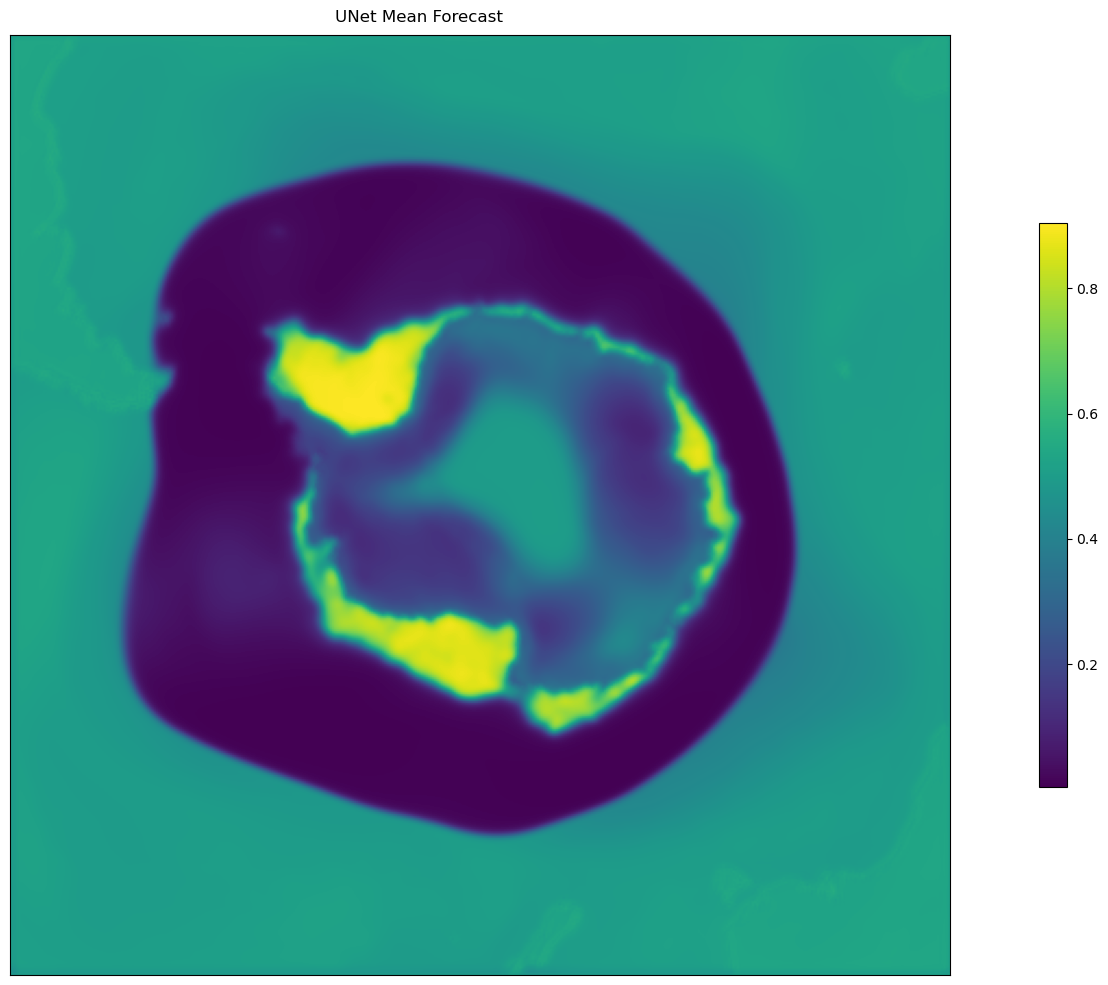

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 10))

plt.imshow(prediction[0, :, :, 0, 0])
plt.xticks([])
plt.yticks([])
plt.colorbar(shrink=0.6)

plt.suptitle("UNet Mean Forecast")
plt.tight_layout()
plt.show()

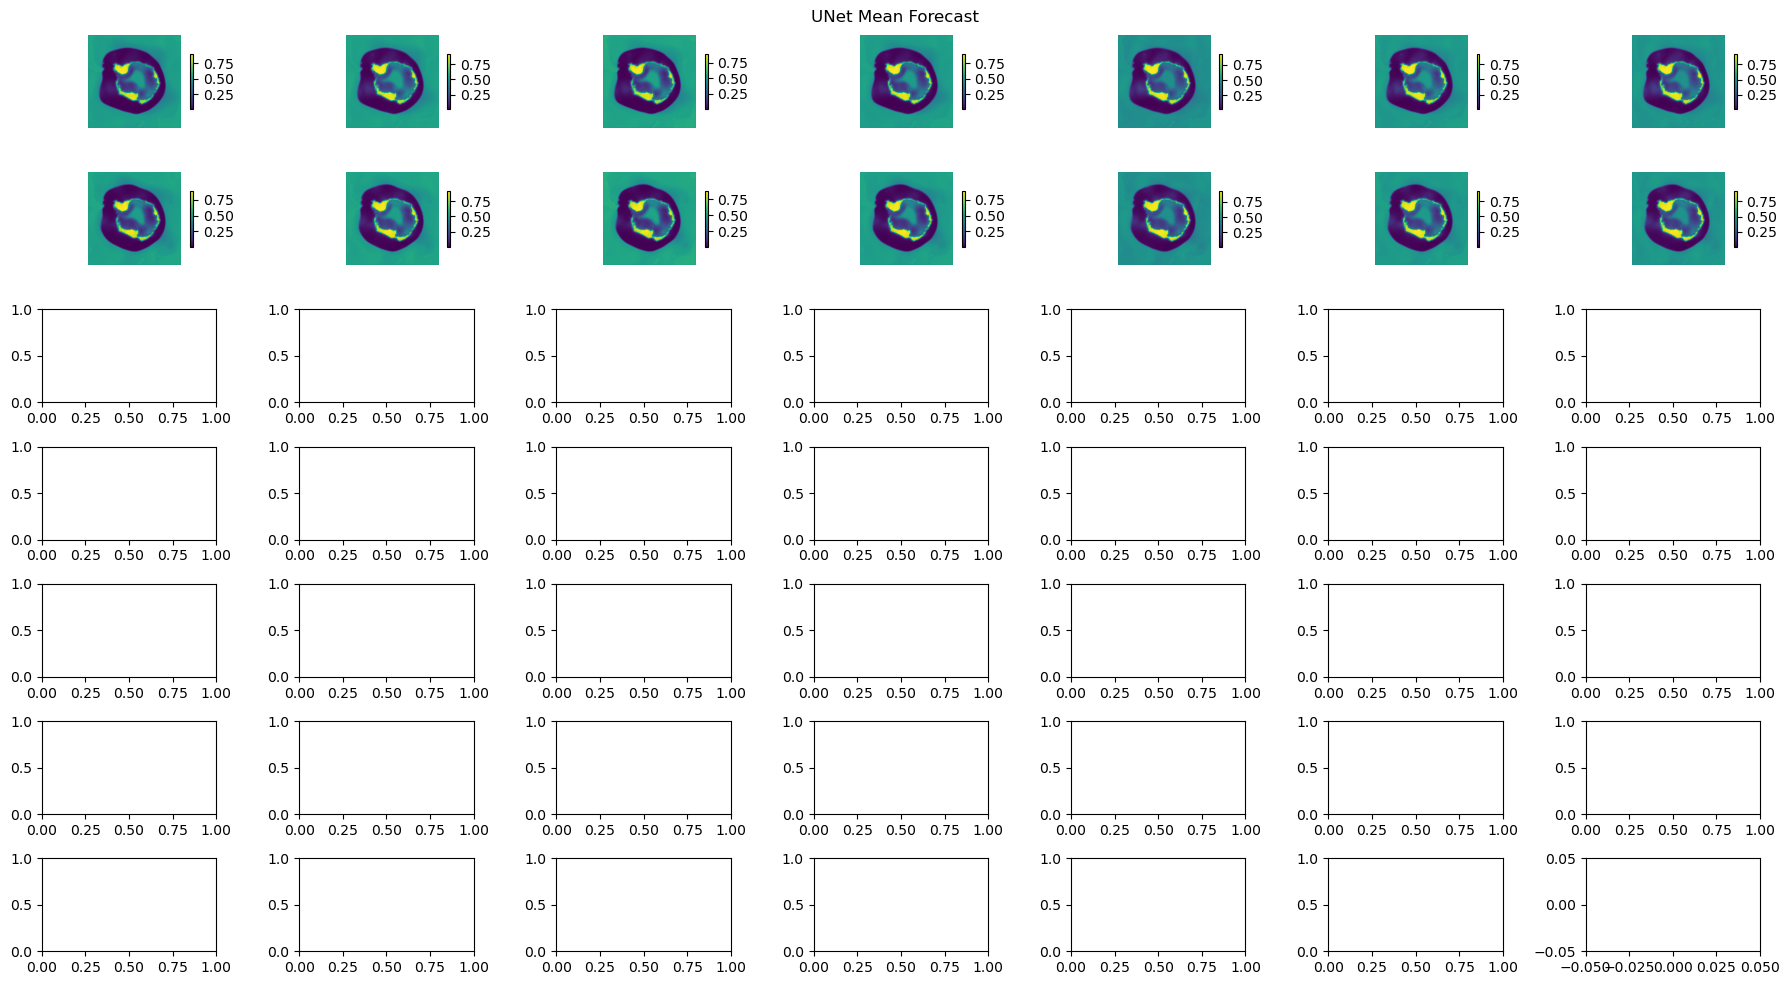

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(7, 7, figsize=(18, 10))
ax = ax.ravel()

idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        # print(idx, worker, batch, prediction.shape, prediction[0, :, :, :, 0].shape)
        for day in range(prediction.shape[-1]): # Loop through no. of forecast days (currently 7)
            im = ax[idx].imshow(prediction[batch, :, :, 0, day], extent=[0, 1, 0, 1])
            ax[idx].axis("off")
            plt.colorbar(im, ax=ax[idx], shrink=0.6)
            idx += 1


plt.suptitle("UNet Mean Forecast")
plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(0)
plt.tight_layout()
plt.show()

Create prediction output directory

In [40]:
dataset = "pytorch_notebook"
network_name = "api_dataset"
output_name = "example_pytorch_forecast"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [41]:
batch = 0
batch_size = prediction.shape[0]

idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

In [42]:
!icenet_output -o results/predict example_pytorch_forecast api_dataset testdates.csv -m

2023-12-27 21:32:07.879349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 21:32:07.879448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 21:32:07.881347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[27-12-23 21:32:12 :INFO    ] - Loading configuration ./dataset_config.api_dataset.json
[27-12-23 21:32:12 :INFO    ] - Training dataset path: ./network_datasets/api_dataset/south/train
[27-12-23 21:32:12 :INFO    ] - Validation dataset path: ./network_datasets/api_dataset/south/val
[27-12-23 21:32:12 :INFO    ] - Test dataset path: ./network_datasets/api_dataset

Plotting the forecast

In [43]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [44]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

In [45]:
forecast_date = ds.time.values[0]
print(forecast_date)

2020-04-01T00:00:00.000000000


In [46]:
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=4, mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Check min/max of predicted SIC fraction

In [47]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

(1, 432, 432)
First forecast day min: 0.0037, max: 0.8949


Load original input dataset

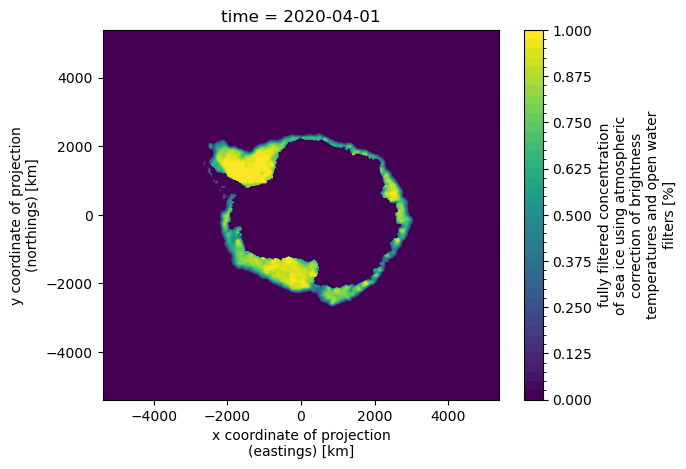

In [48]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=91).ice_conc, levels=50)

# Load processed - normalised dataset
# xr.plot.contourf(xr.open_dataset("processed/notebook_data/osisaf/south/siconca/siconca_abs.nc").isel(time=91).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.7_dev